In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Download the dataset as a zip file
!kaggle datasets download -d ankit1743/skyview-an-aerial-landscape-dataset

Dataset URL: https://www.kaggle.com/datasets/ankit1743/skyview-an-aerial-landscape-dataset
License(s): CC0-1.0
100% 154M/154M [00:09<00:00, 21.1MB/s]
100% 154M/154M [00:09<00:00, 16.8MB/s]


In [3]:
# Unzip the data
!unzip /content/skyview-an-aerial-landscape-dataset.zip

Strømmer utdata som er avkortet til de siste 5000 linjene.
  inflating: Aerial_Landscapes/Lake/601.jpg  
  inflating: Aerial_Landscapes/Lake/602.jpg  
  inflating: Aerial_Landscapes/Lake/603.jpg  
  inflating: Aerial_Landscapes/Lake/604.jpg  
  inflating: Aerial_Landscapes/Lake/605.jpg  
  inflating: Aerial_Landscapes/Lake/606.jpg  
  inflating: Aerial_Landscapes/Lake/607.jpg  
  inflating: Aerial_Landscapes/Lake/608.jpg  
  inflating: Aerial_Landscapes/Lake/609.jpg  
  inflating: Aerial_Landscapes/Lake/610.jpg  
  inflating: Aerial_Landscapes/Lake/611.jpg  
  inflating: Aerial_Landscapes/Lake/612.jpg  
  inflating: Aerial_Landscapes/Lake/613.jpg  
  inflating: Aerial_Landscapes/Lake/614.jpg  
  inflating: Aerial_Landscapes/Lake/615.jpg  
  inflating: Aerial_Landscapes/Lake/616.jpg  
  inflating: Aerial_Landscapes/Lake/617.jpg  
  inflating: Aerial_Landscapes/Lake/618.jpg  
  inflating: Aerial_Landscapes/Lake/619.jpg  
  inflating: Aerial_Landscapes/Lake/620.jpg  
  inflating: Aerial_L

In [4]:
import os

# Define the dataset path
dataset_path = '/content/Aerial_Landscapes'

# Get the folder names as labels
labels = os.listdir(dataset_path)
print('Labels:', labels)
print(f'No of Classes = {len(labels)}')

Labels: ['Port', 'Railway', 'Highway', 'Grassland', 'Airport', 'Forest', 'Residential', 'Mountain', 'Desert', 'Beach', 'City', 'Agriculture', 'Parking', 'Lake', 'River']
No of Classes = 15


In [5]:
image_paths = []
image_labels = []

# Traverse the dataset directory
for label in labels:
    folder_path = os.path.join(dataset_path, label)

    # Get all image files in the folder
    for img_file in os.listdir(folder_path):
        image_paths.append(os.path.join(folder_path, img_file))
        image_labels.append(label)

# Print the first few paths and labels
for path, label in zip(image_paths[:5], image_labels[:5]):
    print(f'Image Path: {path} | Label: {label}')


Image Path: /content/Aerial_Landscapes/Port/195.jpg | Label: Port
Image Path: /content/Aerial_Landscapes/Port/324.jpg | Label: Port
Image Path: /content/Aerial_Landscapes/Port/001.jpg | Label: Port
Image Path: /content/Aerial_Landscapes/Port/308.jpg | Label: Port
Image Path: /content/Aerial_Landscapes/Port/565.jpg | Label: Port


In [6]:
import os
from sklearn.model_selection import train_test_split

# Prepare the list of image paths and their corresponding labels
image_paths = []
image_labels = []

for label in labels:
    folder_path = os.path.join(dataset_path, label)

    # Get all image files in the folder
    for img_file in os.listdir(folder_path):
        image_paths.append(os.path.join(folder_path, img_file))
        image_labels.append(label)

# Check if image_paths and image_labels are the same length
print(f'Total images: {len(image_paths)}, Total labels: {len(image_labels)}')

# Split into train and temp (validation + test) sets
train_paths, temp_paths, train_labels, temp_labels = train_test_split(image_paths, image_labels, test_size=0.3, stratify=image_labels, random_state=42)

# Split temp into validation and test sets
val_paths, test_paths, val_labels, test_labels = train_test_split(temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)

# Print the sizes of each set
print(f'Training set size: {len(train_paths)}')
print(f'Validation set size: {len(val_paths)}')
print(f'Test set size: {len(test_paths)}')
# 70% training, 15% validation, and 15% test data.

Total images: 12000, Total labels: 12000
Training set size: 8400
Validation set size: 1800
Test set size: 1800


In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

# Custom Dataset Class for our project or task
class ImageDataset(Dataset):
    # Initialize the dataset with image paths, labels, and optional transformations
    def __init__(self, image_paths, image_labels, transform=None):
        self.image_paths = image_paths
        self.label_mapping = {label: idx for idx, label in enumerate(set(image_labels))}
        self.image_labels = [self.label_mapping[label] for label in image_labels]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        image = Image.open(self.image_paths[idx]).convert('RGB')

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)

        # Get label
        label = self.image_labels[idx]

        label = torch.tensor(label, dtype=torch.long)

        return image, label


In [8]:
import torchvision.transforms as transforms

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resize images to 224x224 pixels (adjust as needed)
    transforms.ToTensor(),         # Convert image to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # Normalize with mean and std
])

In [9]:
# Create datasets
train_dataset = ImageDataset(train_paths, train_labels, transform=transform)
val_dataset = ImageDataset(val_paths, val_labels, transform=transform)
test_dataset = ImageDataset(test_paths, test_labels, transform=transform)

In [10]:
# Hyperparameters
batch_size = 32
num_workers = 2  # Adjust based on your system's capabilities (only if we have a GPU)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [25]:
import torch
from torchvision.models import vgg16, resnet50, efficientnet_b0, VGG16_Weights, ResNet50_Weights, EfficientNet_B0_Weights
import torch.optim as optim
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize models, optimizers, and criterion for each model
models = [resnet50(weights=ResNet50_Weights.DEFAULT), vgg16(weights=VGG16_Weights.DEFAULT), efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)]

train_losses = [[],[],[]]
val_losses = [[],[],[]]
train_accuracies = [[],[],[]]
val_accuracies = [[],[],[]]

num_epochs = 10

for i, model in enumerate(models):
      model = models[i]
      model = model.to(device)
      criterion = nn.CrossEntropyLoss()
      optimizer = optim.Adam(model.parameters(), lr=0.001)

      for epoch in range(num_epochs):

        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_losses[i].append(train_loss)
        train_accuracy = 100 * correct / total
        train_accuracies[i].append(train_accuracy)

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_losses[i].append(val_loss)
        val_accuracy = 100 * correct / total
        val_accuracies[i].append(val_accuracy)

        print(f'Model {i+1} - Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')


Model 1 - Epoch 1/10, Train Loss: 1.9224, Train Accuracy: 39.57%, Val Loss: 2.9386, Val Accuracy: 31.50%
Model 1 - Epoch 2/10, Train Loss: 1.4506, Train Accuracy: 52.60%, Val Loss: 2.6750, Val Accuracy: 41.78%
Model 1 - Epoch 3/10, Train Loss: 1.2100, Train Accuracy: 60.01%, Val Loss: 2.5106, Val Accuracy: 46.39%
Model 1 - Epoch 4/10, Train Loss: 1.0975, Train Accuracy: 64.00%, Val Loss: 3.0972, Val Accuracy: 47.44%
Model 1 - Epoch 5/10, Train Loss: 1.0127, Train Accuracy: 67.02%, Val Loss: 2.7935, Val Accuracy: 45.89%
Model 1 - Epoch 6/10, Train Loss: 0.9049, Train Accuracy: 70.40%, Val Loss: 3.7752, Val Accuracy: 38.72%
Model 1 - Epoch 7/10, Train Loss: 0.8218, Train Accuracy: 73.26%, Val Loss: 2.9189, Val Accuracy: 51.61%
Model 1 - Epoch 8/10, Train Loss: 0.7765, Train Accuracy: 74.93%, Val Loss: 3.9583, Val Accuracy: 42.78%
Model 1 - Epoch 9/10, Train Loss: 0.6991, Train Accuracy: 77.23%, Val Loss: 2.8515, Val Accuracy: 54.89%
Model 1 - Epoch 10/10, Train Loss: 0.6368, Train Accura

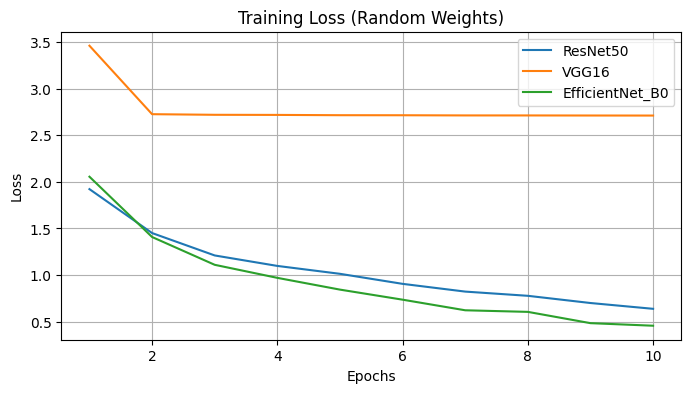

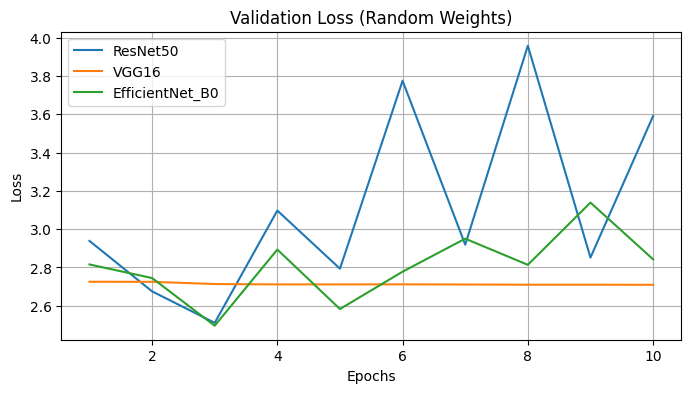

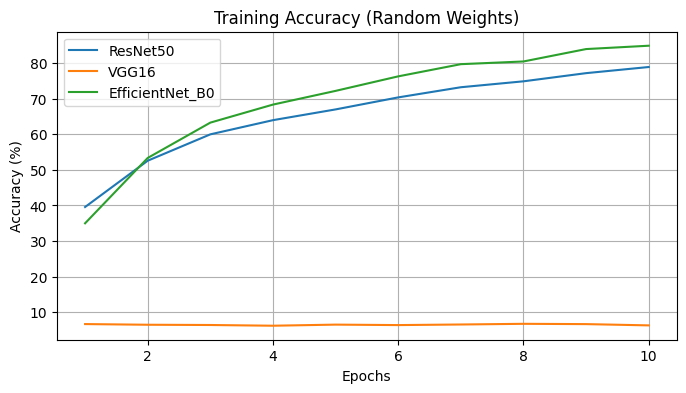

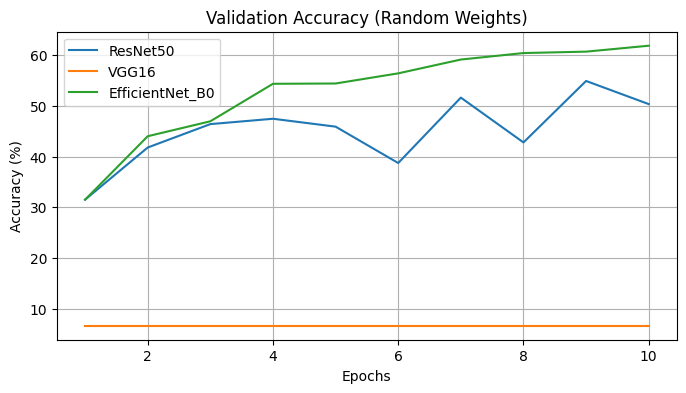

In [26]:
import matplotlib.pyplot as plt
modelname = ['ResNet50', 'VGG16', 'EfficientNet_B0']
# Plot training loss
plt.figure(figsize=(8,4))
for i in range(3):
  plt.plot(range(1, len(val_losses[i])+1), train_losses[i], label=modelname[i])
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss (Random Weights)')
plt.legend()
plt.show()

#Plot validation loss
plt.figure(figsize=(8,4))
for i in range(3):
  plt.plot(range(1, len(val_losses[i])+1), val_losses[i], label=modelname[i])
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss (Random Weights)')
plt.legend()
plt.show()

#Plot training accuracy
plt.figure(figsize=(8,4))
for i in range(3):
  plt.plot(range(1, len(val_losses[i])+1), train_accuracies[i], label=modelname[i])
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy (Random Weights)')
plt.legend()
plt.show()

#Plot validation accuracy
plt.figure(figsize=(8,4))
for i in range(3):
  plt.plot(range(1, len(val_losses[i])+1), val_accuracies[i], label=modelname[i])
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy (Random Weights)')
plt.legend()
plt.show()